In [80]:
import numpy as np
import time
import scipy.stats as stats
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

# Explore and extra data of particular periods of interest

In [5]:
data = pd.read_sas('/home/guangya/Downloads/wnv_2245new.sas7bdat') #Data from week 22 to 45, which is what i used for latter models

In [6]:
data.head() # Available features in the data set, More description is the final.xlsw file

,hexid,Input_FID,tempc,preci,yr,weeks,yrweeks,yrwksfid,templag1,templag2,...,wwpct,ehwpct,yr_hexid,Jantemp,PopYesNo,hpctpreww,hpctpostww,hpct7089,hpctpost90,income1
0,1.0,130.0,16.9758,6.046130,2005.0,22.0,b'200522',b'200522130',15.9957,13.7796,...,27.184466,0.0,"b'2005,1'",-3.815482,1.0,0.0,0.0,0.0,0.0,41.979816
1,1.0,130.0,25.3449,58.968242,2005.0,23.0,b'200523',b'200523130',16.9758,15.9957,...,27.184466,0.0,"b'2005,1'",-3.815482,1.0,0.0,0.0,0.0,0.0,41.979816
2,1.0,130.0,21.0872,15.114200,2005.0,24.0,b'200524',b'200524130',25.3449,16.9758,...,27.184466,0.0,"b'2005,1'",-3.815482,1.0,0.0,0.0,0.0,0.0,41.979816
3,1.0,130.0,22.3485,0.000000,2005.0,25.0,b'200525',b'200525130',21.0872,25.3449,...,27.184466,0.0,"b'2005,1'",-3.815482,1.0,0.0,0.0,0.0,0.0,41.979816
4,1.0,130.0,25.7740,6.371029,2005.0,26.0,b'200526',b'200526130',22.3485,21.0872,...,27.184466,0.0,"b'2005,1'",-3.815482,1.0,0.0,0.0,0.0,0.0,41.979816


In [9]:
data.isna().sum() # Check na

hexid               0
Input_FID           0
tempc               0
preci               0
yr                  0
weeks               0
yrweeks             0
yrwksfid            0
templag1            0
templag2            0
templag3            0
templag4            0
precilag1           0
precilag2           0
precilag3           0
precilag4           0
wnvbinary           0
mirmean             0
year           150510
mirlag1             0
mirlag2             0
mirlag3             0
mirlag4             0
totpop              0
whitepct            0
blackpct            0
asianpct            0
hispanicpct         0
Income              0
owpct               0
dospct              0
dlipct              0
dmipct              0
dhipct              0
blpct               0
dfpct               0
efpct               0
mfpct               0
shrubpct            0
glandpct            0
pasturepct          0
ccpct               0
wwpct               0
ehwpct              0
yr_hexid            0
Jantemp   

In [10]:
data.drop(columns=['wnvbinary','yrweeks','yrwksfid','yr_hexid','year']).isna().sum() # Drop year column so that so na appear

hexid          0
Input_FID      0
tempc          0
preci          0
yr             0
weeks          0
templag1       0
templag2       0
templag3       0
templag4       0
precilag1      0
precilag2      0
precilag3      0
precilag4      0
mirmean        0
mirlag1        0
mirlag2        0
mirlag3        0
mirlag4        0
totpop         0
whitepct       0
blackpct       0
asianpct       0
hispanicpct    0
Income         0
owpct          0
dospct         0
dlipct         0
dmipct         0
dhipct         0
blpct          0
dfpct          0
efpct          0
mfpct          0
shrubpct       0
glandpct       0
pasturepct     0
ccpct          0
wwpct          0
ehwpct         0
Jantemp        0
PopYesNo       0
hpctpreww      0
hpctpostww     0
hpct7089       0
hpctpost90     0
income1        0
dtype: int64

In [11]:
x_total = data.drop(columns=['wnvbinary','yrweeks','yrwksfid','yr_hexid','year']).values # Drop extra column
y_total = data['wnvbinary'].values

In [12]:
x_total = x_total.astype('float64')

In [13]:
# some spot check for data
data[data['hexid'] == 1431]['blackpct'].unique()

array([4.28479215])

In [14]:
data[data['hexid'] == 1831]['whitepct'].unique()

array([86.10261915])

In [15]:
data[data['hexid'] == 1831]['dmipct'].unique() 

array([14.42441054])

In [16]:
data[data['hexid'] == 3121]['income1'].unique() # The Geological and social data is likely a 10 year estimate here, which does not change from 2005-2016

array([100.88401563])

In [17]:
x = data[['yr','templag2','templag3','templag4','precilag2','mirlag1','mirlag2','mirlag3','mirlag4', 'whitepct','owpct','dmipct','dhipct']].values
# Data set for the best model described in paper, table5.
# However, random forest use a different feature selection algorithm 
# so that this might not be the optimal one for oue models. Since it's much slower to train all, I will use ALL features for further optimization later
y = data['wnvbinary'].values 
x = x.astype('float64')

In [18]:
trainX, testX, trainY, testY = train_test_split(x, y, test_size = 0.2, shuffle = True) # CV

In [19]:
trainX_total, testX_total, trainY_total, testY_total = train_test_split(x_total, y_total, test_size = 0.2, shuffle = True) # CV for all

In [34]:
data_mid_summer = data[data['weeks'] <= 33]
data_mid_summer = data_mid_summer[data_mid_summer['weeks'] >= 28]
# Data set for the mid-summer only, maybe used later

# Test on Random Forest

In [98]:
def model_RF_test(model_RF, dataX, dataY):
    print("Model performance")
    predict_data = model_RF.predict_proba(dataX)
    
    # Some stats
    print("Feature Importantce : ")
    print(model_RF.feature_importances_)
    print("Total number of WNV occurence in test set : " + str(len(dataY[dataY > 0])))
    
    print("Number of WNV occurence the model is able to capture in test set:" + str(dataY[np.where(predict_data[:,1]  > 0)].sum()))
    
    print("Log loss : " + str(log_loss(dataY,predict_data)))
    
    print("This is to test the performance of random forest model, ideally, the logloss is low and also it is able to capture most of the WNV occurence")
    
    return None # Check how many wnv it predicts

In [95]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(trainX_total, trainY_total)
time_start = time.time()
model_RF1 = RandomForestClassifier(n_estimators=400,
                                 n_jobs = -1,
                                 max_features=None,
                                 max_depth= None,
                                 bootstrap=True,
                                class_weight='balanced'
                                 ) # Use undersampling to see if it worked
model_RF1.fit(X_resampled, y_resampled)
print("time consumed:", time.time() - time_start) 

time consumed: 1.8904671669006348


In [96]:
model_RF1.feature_importances_

In [ ]:
ypred_prob1 = model_RF1.predict_proba(testX_total)

In [97]:
log_loss(testY_total,ypred_prob1[:,1])

0.4219614144734439

In [98]:
model_RF_test(model_RF1,testX_total,testY_total) # The result tend to predict a lot of 1s, which is very biased.

Model performance
precision,recall,and fscore (0.5012200289355818, 0.8239998854296045, 0.45602242627122336, None)


49279.0

In [34]:
# A reminder: When I tried to use MAE as the criterion of RandomForestRegressor, I found that it took so much time,
# and that's beacuase the scikilt-learn::RandomForest package has some problems when dealing with MAE.
# The discuss link is: https://github.com/scikit-learn/scikit-learn/issues/9626
# This problem is stil not solved. If you are interested, you can take part in solving that through this link.
# Currently, MAE took N(O^2) time, so be careful to use that.

In [16]:
time_start = time.time()
model_RF2 = RandomForestClassifier(n_estimators=200,
                                 n_jobs = -1,
                                 max_features="sqrt",
                                 max_depth= None,
                                 bootstrap=True,
                                class_weight='balanced' # weighted class
                                 ) # Models for best features based on paper
model_RF2.fit(trainX, trainY)
print("time consumed:", time.time() - time_start)

time consumed: 240.13485527038574


In [19]:
model_RF_test(model_RF2,testX,testY)

Model performance
precision,recall,and fscore (0.4997197037857291, 0.5, 0.49985981259886675, None)


/home/guangya/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [28]:
model_RF_test(model_RF2,trainX,trainY)

Model performance
precision,recall,and fscore (1.0, 1.0, 1.0, None)


733.0

In [30]:
model_RF2.feature_importances_ # mir lag and temp lag seems to be the most important features 

array([0.02628356, 0.09209969, 0.10388941, 0.10300202, 0.04297687,
       0.12935102, 0.14625665, 0.11372493, 0.07804707, 0.04286975,
       0.02040079, 0.05827969, 0.04281854])

In [37]:
ypred_prob2 = model_RF2.predict_proba(testX)

In [38]:
ypred_prob2[ypred_prob2[:,1] > 0] # Check the probability, want to see if this provides some insights

array([[0.995, 0.005],
       [0.995, 0.005],
       [0.99 , 0.01 ],
       ...,
       [0.995, 0.005],
       [0.985, 0.015],
       [0.995, 0.005]])

In [40]:
testY[np.where(ypred_prob2[:,1]  > 0.01)].sum() 

17.0

In [44]:
len(ypred_prob2[ypred_prob2[:,1]  > 0.01]) #  17 out of 2897 are predicted, Sort of overprediction here

2897

In [46]:
len(ypred_prob2[ypred_prob2[:,1]  > 0]) # rows that has a non-zero probability

16286

In [48]:
len(ypred_prob2) # total rows

288980

In [51]:
testY[np.where(ypred_prob2[:,1]  > 0)].sum() # This should be about 150, this is not good but promising?

56.0

In [52]:
testY.sum() # This is certainly a pattern here since about 1/3 of all wnv binary are found from about 1/20 of the data

162.0

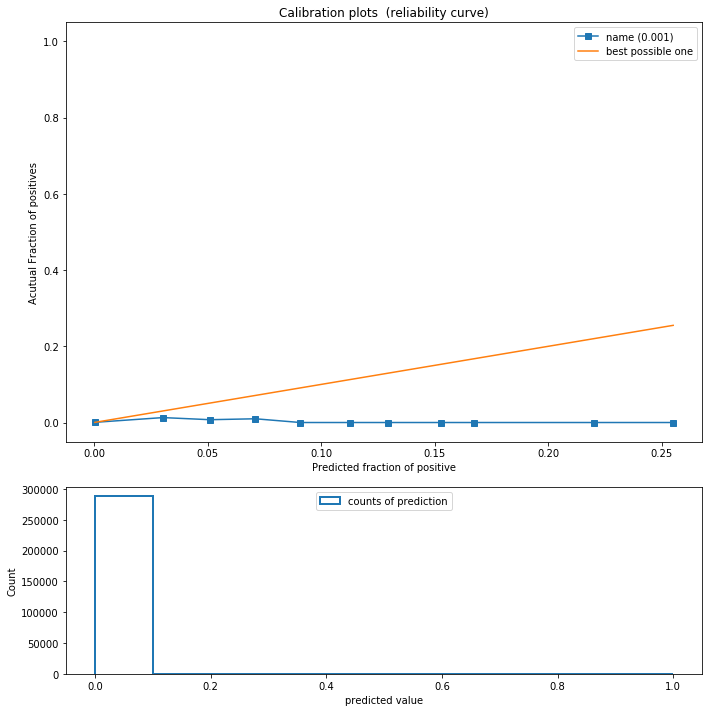

In [62]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
clf_score = brier_score_loss(testY_total, ypred_prob2[:,1], pos_label=1)
fraction_of_positives, mean_predicted_value = \
    calibration_curve(testY_total, ypred_prob2[:,1], n_bins=50)
# x_temp = np.linspace(0,0.3,100)
# y_temp = x
# ax1.plot(x, y, '-r', label='y=x, the best possible curve')
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s (%1.3f)" % ('name', clf_score))
ax1.plot(mean_predicted_value,mean_predicted_value,label = "best possible one")
ax1.set_xlabel("Predicted fraction of positive")
ax2.hist(ypred_prob2[:,1], range=(0, 1), bins=10, label='counts of prediction',
         histtype="step", lw=2)
ax1.set_ylabel("Acutual Fraction of positives")
ax1.set_ylim([-0.05, 1.05])

ax1.legend(loc="upper right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout() 

# Note: Calibration curve migth not be a vert good idea to check the models here since 
# there are very few values that is greater than 0.05, but a lot of them are smaller than 0.01
# Use Logloss which is used by Kaggle instead

In [64]:
# Some other metrics

In [81]:
log_loss(testY,ypred_prob2[:,1])

0.014095789746417599

In [83]:
log_loss(testY_total,ypred_prob3[:,1])

0.011415605624546486

In [63]:
time_start = time.time()
model_RF3 = RandomForestClassifier(n_estimators=400,
                                 n_jobs = -1,
                                 max_features=None,
                                 max_depth= None,
                                 bootstrap=True,
                                class_weight='balanced'
                                 ) # Try more trees and see if calibration curve gets better
model_RF3.fit(trainX_total, trainY_total)
print("time consumed:", time.time() - time_start) 

time consumed: 3830.862540960312


In [99]:
model_RF_test(model_RF3,testX_total,testY_total)

Model performance
precision,recall,and fscore (0.49973354557408817, 0.5, 0.4998667372786022, None)


/home/guangya/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [65]:
ypred_prob3 =  model_RF3.predict_proba(testX_total)

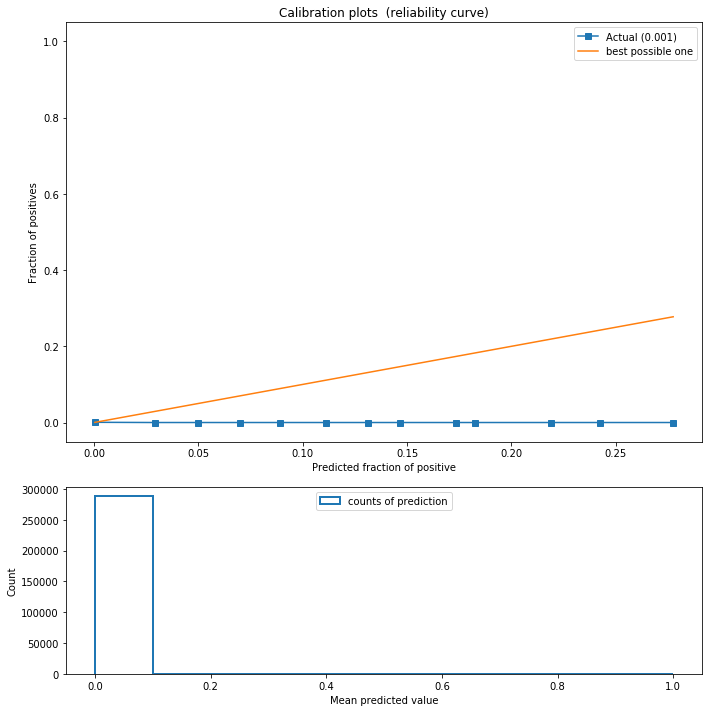

In [67]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
clf_score = brier_score_loss(testY, ypred_prob3[:,1], pos_label=1)
fraction_of_positives, mean_predicted_value = \
    calibration_curve(testY, ypred_prob3[:,1], n_bins=50)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s (%1.3f)" % ('Actual', clf_score))
ax1.plot(mean_predicted_value,mean_predicted_value,label = "best possible one")
ax1.set_xlabel("Predicted fraction of positive")
ax2.hist(ypred_prob3[:,1], range=(0, 1), bins=10, label='counts of prediction',
         histtype="step", lw=2)
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

In [69]:
testY_total[np.where(ypred_prob3[:,1]  > 0.01)].sum()  # Try same procedure as the above model

34.0

In [70]:
len(ypred_prob3[ypred_prob3[:,1]  > 0.01])

3976

In [71]:
len(ypred_prob3[ypred_prob3[:,1]  > 0]) #  # of prediction that has a probability > 0

22663

In [72]:
len(ypred_prob3)# total rows

288980

In [76]:
testY_total.sum()  #  # of wnv occurence

154.0

In [75]:
testY_total[np.where(ypred_prob3[:,1]  > 0)].sum() # For all wnv predicted probability > 0, how many are atucally 1

74.0

In [104]:
data.drop(columns=['wnvbinary','yrweeks','yrwksfid','yr_hexid','year']).columns[[17,20,9,10,16,18]]

Index(['mirlag3', 'whitepct', 'templag4', 'precilag1', 'mirlag2', 'mirlag4'], dtype='object')

In [77]:
model_RF3.feature_importances_ # The Top 6 most important features here are 

array([8.88704331e-03, 8.84480099e-03, 1.68290411e-02, 1.52045984e-02,
       5.75101814e-03, 2.78785486e-02, 2.04788789e-02, 2.83668125e-02,
       4.98446764e-02, 3.64082202e-02, 1.49555824e-02, 1.42035148e-02,
       1.65239836e-02, 1.22510462e-02, 1.74641244e-02, 5.91554695e-02,
       2.94205558e-01, 3.33941271e-02, 1.77255609e-02, 1.24203733e-01,
       7.01655983e-03, 9.02628399e-03, 8.68760901e-03, 1.06382525e-02,
       5.50246837e-03, 4.21082086e-03, 9.72809643e-03, 1.17033932e-02,
       1.08153860e-02, 9.16551879e-03, 1.04612043e-03, 2.24494907e-03,
       1.35438082e-03, 2.70110347e-03, 4.88967833e-04, 1.61098103e-03,
       7.41166045e-04, 1.21171795e-03, 1.59101536e-03, 1.34623913e-04,
       2.37460250e-02, 0.00000000e+00, 1.15473649e-02, 1.07359273e-02,
       1.14455357e-02, 1.47627672e-02, 5.56662678e-03])

In [239]:
# With more tree, it has a worse looking calibaration curves, but it is able to capture more wnv binary. This is mostly because there are few points that is greater than 0.1, so
# there is a lot of variance here.

In [258]:
time_start = time.time()
model_RF4 = RandomForestClassifier(n_estimators=800,
                                 n_jobs = -1,
                                 max_features=None,
                                 max_depth= None,
                                 bootstrap=True,
                                class_weight='balanced'
                                 ) # Try more trees and see if calibration curve gets better
model_RF4.fit(dataX, dataY)
print("time consumed:", time.time() - time_start) 

time consumed: 2579.3949797153473


In [260]:
model_RF4.feature_importances_

array([0.01850711, 0.0823149 , 0.10578664, 0.0650007 , 0.04608133,
       0.06198855, 0.3301192 , 0.0787663 , 0.05056812, 0.03990346,
       0.02038123, 0.0661462 , 0.03443626])

In [107]:
data[['yr','templag2','templag3','templag4','precilag2','mirlag1','mirlag2','mirlag3','mirlag4', 'whitepct','owpct','dmipct','dhipct']].columns[[2,3,6,7,8]]

Index(['templag3', 'templag4', 'mirlag2', 'mirlag3', 'mirlag4'], dtype='object')

In [ ]:
data[data.drop(columns=['wnvbinary','yrweeks','yrwksfid','yr_hexid','year']).columns[[7,8,9,10,16,17,20]]] # From the above 3 feature importance of models, we can manually select 
# about 7 features which is mostly important

In [268]:
ypred_RF4 = model_RF4.predict_proba(testX)

In [275]:
testY[np.where(ypred_RF4[:,1]  > 0.1)].sum()

1.0

In [277]:
len(ypred_RF4[ypred_RF4[:,1]  > 0.1])

48

In [278]:
testY[np.where(ypred_RF4[:,1]  > 0.01)].sum() 

27.0

In [279]:
len(ypred_RF4[ypred_RF4[:,1]  > 0.01])

3566

In [280]:
ypred_RF4[ypred_RF4[:,1] > 0][:,1].mean()

0.005120444741930686

In [282]:
len(ypred_RF4[ypred_RF4[:,1]  > 0])

33615

In [286]:
testY.sum()

176.0

In [285]:
testY[np.where(ypred_RF4[:,1]  > 0)].sum()

94.0

NameError: name 'ypred_RF4' is not defined

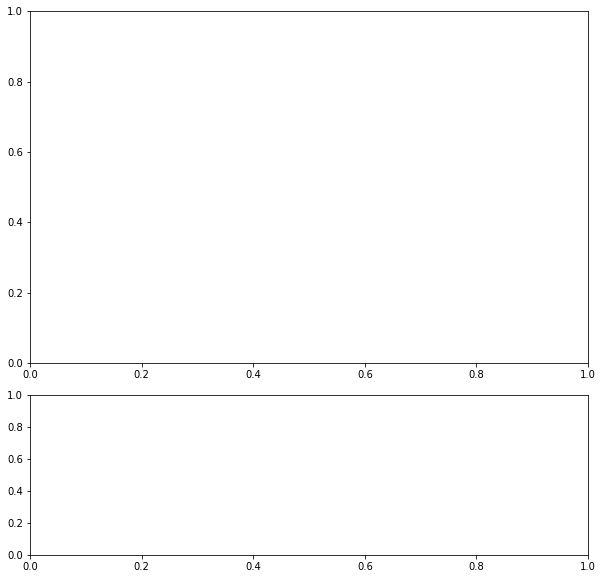

In [77]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
clf_score = brier_score_loss(testY, ypred_RF4[:,1], pos_label=1)
fraction_of_positives, mean_predicted_value = \
    calibration_curve(testY, ypred_RF4[:,1], n_bins=30)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s (%1.3f)" % ('Actual', clf_score))
ax1.plot(mean_predicted_value,mean_predicted_value,label = "best possible one")
ax1.set_xlabel("Predicted fraction of positive")
ax2.hist(ypred_RF4[:,1], range=(0, 1), bins=10, label='counts of prediction',
         histtype="step", lw=2)
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

In [32]:
x_selected = data[data.drop(columns=['wnvbinary','yrweeks','yrwksfid','yr_hexid','year']).columns[[7,8,9,10,16,17,20]]]
y_selected = y

In [ ]:
x

### From the above model, we can see that random forest, although is not very good, can actually capture someinformation. So we will try formal Cross validation on selected features and see if it gets betterz

## Pipnelines for later for wrok

In [44]:
trainX_sel, testX_sel, trainY_sel, testY_sel = train_test_split(x_selected.values, y_selected, test_size = 0.2, shuffle = True) # CV

## Find best model 1

In [39]:
time_start = time.time()
params_RF_grid_1 = {
    'n_estimators' : [500, 1000],
    'max_features' : [90, 'sqrt', None],
    'max_depth' : [10, None],
    'min_samples_leaf' : [1,2]
}
CV_model_RF_1 = GridSearchCV(model_RF, params_RF_grid_1, scoring='neg_log_loss',cv=5)
CV_model_RF_1.fit(x_selected, dataY)
print("time consumed:", time.time() - time_start)

time consumed: 6569.04248213768


In [40]:
CV_model_RF_1.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [41]:
CV_model_RF_1.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'n_estimators': 1000}

In [54]:
time_start = time.time()
model_RF_best_1 = RandomForestClassifier(n_estimators=800,
                                 n_jobs = -1,
                                 max_features="sqrt",
                                 max_depth=None,
                                 bootstrap=True,
                                 min_samples_leaf=2
                                 )
model_RF_best_1.fit(trainX_sel,trainY_sel)
print("Time consumed:", time.time() - time_start)

Time consumed: 902.6136860847473


In [55]:
sth = model_RF_best_1.predict_proba(testX_sel)

In [56]:
model_RF_best_1.feature_importances_

array([0.15362526, 0.15291008, 0.15199803, 0.13824163, 0.14013906,
       0.13901935, 0.12406659])

In [67]:
testY_sel[np.where(sth[:,1]  > 0)].sum() 

127.0

In [75]:
len(testY_sel[testY_sel > 0])

174

In [88]:
len(sth[sth[:,1]  > 0])

68106

In [99]:
model_RF_test(model_RF_best_1,testX_sel,testY_sel)

Model performance
Feature Importantce : 
[0.15362526 0.15291008 0.15199803 0.13824163 0.14013906 0.13901935
 0.12406659]
Total number of WNV occurence in test set : 174
Number of WNV occurence the model is able to capture in test set:127.0
Log loss : 0.008746820848036466
This is to test the performance of random forest model, ideally, the logloss is low and also it is able to capture most of the WNV occurence


In [90]:
127/68106

0.0018647402578333774

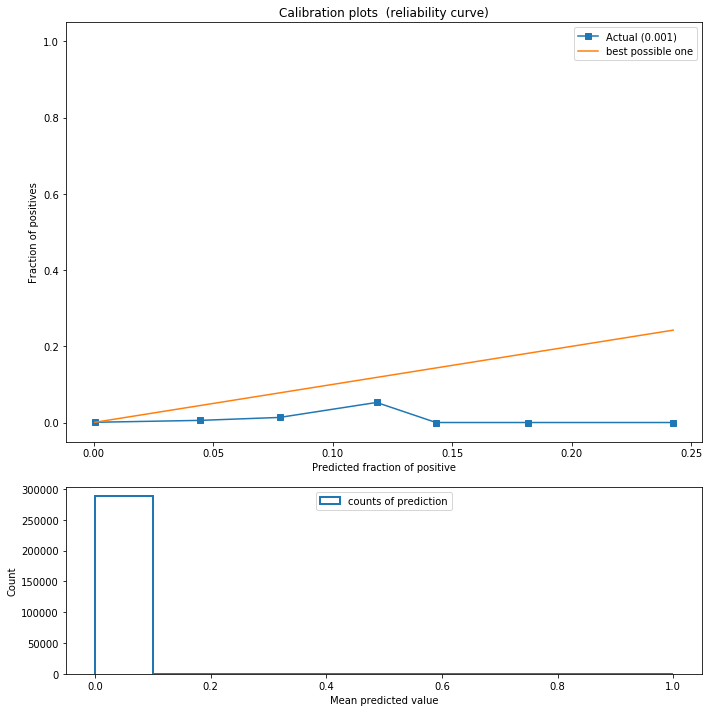

In [87]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
clf_score = brier_score_loss(testY_sel, sth[:,1], pos_label=1)
fraction_of_positives, mean_predicted_value = \
    calibration_curve(testY_sel, sth[:,1], n_bins=30)

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="%s (%1.3f)" % ('Actual', clf_score))
ax1.plot(mean_predicted_value,mean_predicted_value,label = "best possible one")
ax1.set_xlabel("Predicted fraction of positive")
ax2.hist(sth[:,1], range=(0, 1), bins=10, label='counts of prediction',
         histtype="step", lw=2)
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="upper right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

## Find best model 2

In [ ]:
time_start = time.time()
params_RF_grid_2 = {
    'n_estimators' : [800, 1200],
    'max_features' : ['sqrt', 5],
    'min_samples_leaf' : [2,3]
}
CV_model_RF_2 = GridSearchCV(model_RF, params_RF_grid_2, cv=5)
CV_model_RF_2.fit(dataX, dataY)
print("time consumed:", time.time() - time_start)

In [24]:
CV_model_RF_2.fit(dataX, dataY)

KeyboardInterrupt: 

In [ ]:
CV_model_RF_2.best_params_

In [11]:
time_start = time.time()
model_RF_best_2 = RandomForestRegressor(n_estimators=1500,
                                 criterion="mse",
                                 n_jobs = -1,
                                 max_features=None,
                                 max_depth=None,
                                 bootstrap=True,
                                 min_samples_leaf=2
                                 )
model_RF_best_2.fit(trainX, trainY)
print("Time consumed:", time.time() - time_start)

Time consumed: 263.9204020500183


## Find best model 3

In [12]:
time_start = time.time()
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, None, 110],
    'max_features': ['sqrt', 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [500, 2000, 4000, 1000]
}
CV_model_RF_3 = GridSearchCV(model_RF_best_2, params_RF_grid_3, cv=5)
CV_model_RF_3.fit(dataX, dataY)
print("time consumed:", time.time() - time_start)

time consumed: 998.9455091953278


In [13]:
CV_model_RF_3.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=3000,
                      n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [14]:
CV_model_RF_3.best_params_

{'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 3000}

In [51]:
time_start = time.time()
model_RF_best_3 = RandomForestRegressor(n_estimators=8000,
                                 criterion="mse",
                                 n_jobs = -1,
                                 max_features="log2",
                                 max_depth=None,
                                 bootstrap=True,
                                 min_samples_leaf=2
                                 )
model_RF_best_3.fit(trainX, trainY)
print("Time consumed:", time.time() - time_start)

Time consumed: 45.644662857055664
